In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in data from sql_queries
data = pd.read_csv("data/sql_data.csv")

## Extract Project Names from URLs

In [3]:
# This makes assumptions about url structure and project naming
projects = []
for elem in data['url'].str.findall("(.+)/(.+)(/*$)"):
    projects.append(elem[0][1].replace("/",""))
data['project'] = projects


## Calculate the Duration in Days and Months (28 days) for each Project

In [4]:
data['end_date']= pd.to_datetime(data['end_date'], utc=True)
data['start_date']= pd.to_datetime(data['start_date'], utc=True)

In [5]:
# The + 1 represents rounding up to the next day (there are cases where min and max date are equal)
data['duration_days'] = ((data['end_date'] - data['start_date'])/np.timedelta64(1,'D') + 1).astype(int)
# define month as 28 days
data['duration_months'] = (data['duration_days']/28).astype(int)


## Create Revision Frequency Columns

In [6]:
# Create Revision Frequency
data['rev_freq'] = data['rev_count'] / data['duration_days']
# Create column for high frequency vs low frequency
data['high_rev_freq'] = data['rev_freq'] > 1

data['high_rev_freq'].value_counts()

False    1424
True      642
Name: high_rev_freq, dtype: int64

## Determine Whether Projects are Hosted on Multiple Repositories

In [7]:
# These are mistakes, the project and host_type should uniquely identify the repos, but git projects
# can have duplicated names, so these projects are not actually hosted on multiple repos
temp = data.groupby(['project', 'host_type']).count()['censored']
non_multi_repo_projects = [x for (x,y) in temp[temp > 1].index]
non_multi_repo_projects


['Python', 'algorithms', 'dataset', 'models', 'seq2seq', 'sshuttle', 'tqdm']

In [8]:
temp = data.groupby(['project']).count()['censored']
temp[temp == 1] = 0
temp[temp > 1] = 1
# fix errors
temp[non_multi_repo_projects] = 0

multi_repo = []
for i, row in data.iterrows():
    multi_repo.append(temp[row['project']])

data['multi_repo'] = multi_repo
data['multi_repo'] = data['multi_repo'].astype(bool)
data['multi_repo'].value_counts()

False    1955
True      111
Name: multi_repo, dtype: int64

## High Author Count

In [9]:
data['high_author_count'] = data['author_count'] > 20
data['high_author_count'].value_counts()

False    1551
True      515
Name: high_author_count, dtype: int64

## Save to CSVs

In [10]:
data.to_csv("data/all_fields.csv", index=False)

In [11]:
refined = data.drop(['url', 'author_count', 'start_date', 'end_date', 'rev_count', 'project', 'duration_days', 'rev_freq'], axis='columns')
refined.to_csv('data/necessary_fields.csv', index=False)

# Create Figure 1 (Ordered Timeline of Projects)

In [12]:
beginning_month = pd.to_datetime('2005-05-09 00:00:00-07:00', utc=True)
ending_month = pd.to_datetime('2018-01-01 00:00:00-07:00', utc=True)

graph_data = data.copy()
graph_data['start_month'] = (((data['start_date'] - beginning_month)/np.timedelta64(1,'D') + 1)/28).astype(int)
graph_data['end_month'] = (((data['end_date'] - beginning_month)/np.timedelta64(1,'D') + 1)/28).astype(int)
graph_data = graph_data.sort_values(by=['duration_months'])

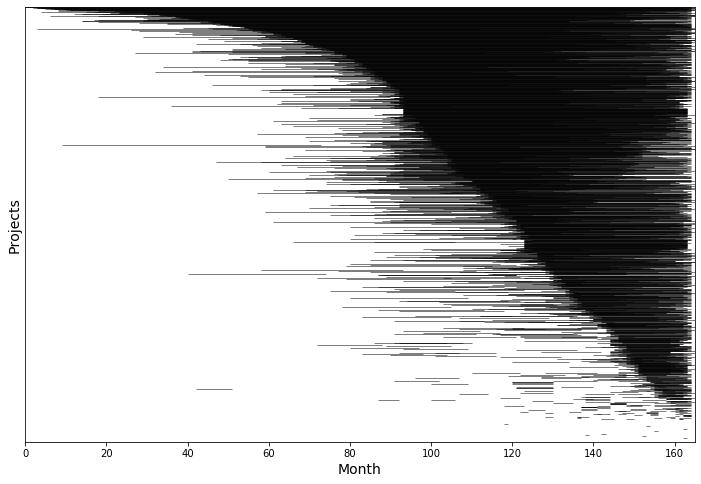

In [14]:
plt.rcParams["figure.figsize"]=[12,8]
plt.hlines(y=np.arange(graph_data.shape[0]), xmin=graph_data['start_month'], xmax=graph_data['end_month'], colors='black', linewidth=0.5)
plt.tick_params(left=False, labelleft=False)
plt.ylabel('Projects', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.xlim((0, int((((ending_month - beginning_month)/np.timedelta64(1,'D'))/28))))
plt.ylim((0, graph_data.shape[0]))
plt.savefig('img/figure1.jpg',bbox_inches='tight', dpi=150)